# Unoffical Stable diffusion by StabilityAI

Leaked stable diffusion weights collab for all humans

twitter haters - fuck yourself

idn, it uses 16+gb ram so you should use collab pro/own car. maybe i will fix it, maybe stability ai gonna fix it

[stability ai blogpost](https://stability-ai.webpkgcache.com/doc/-/s/stability.ai/beta-signup-form)

[offical github](https://github.com/CompVis/stable-diffusion)

______
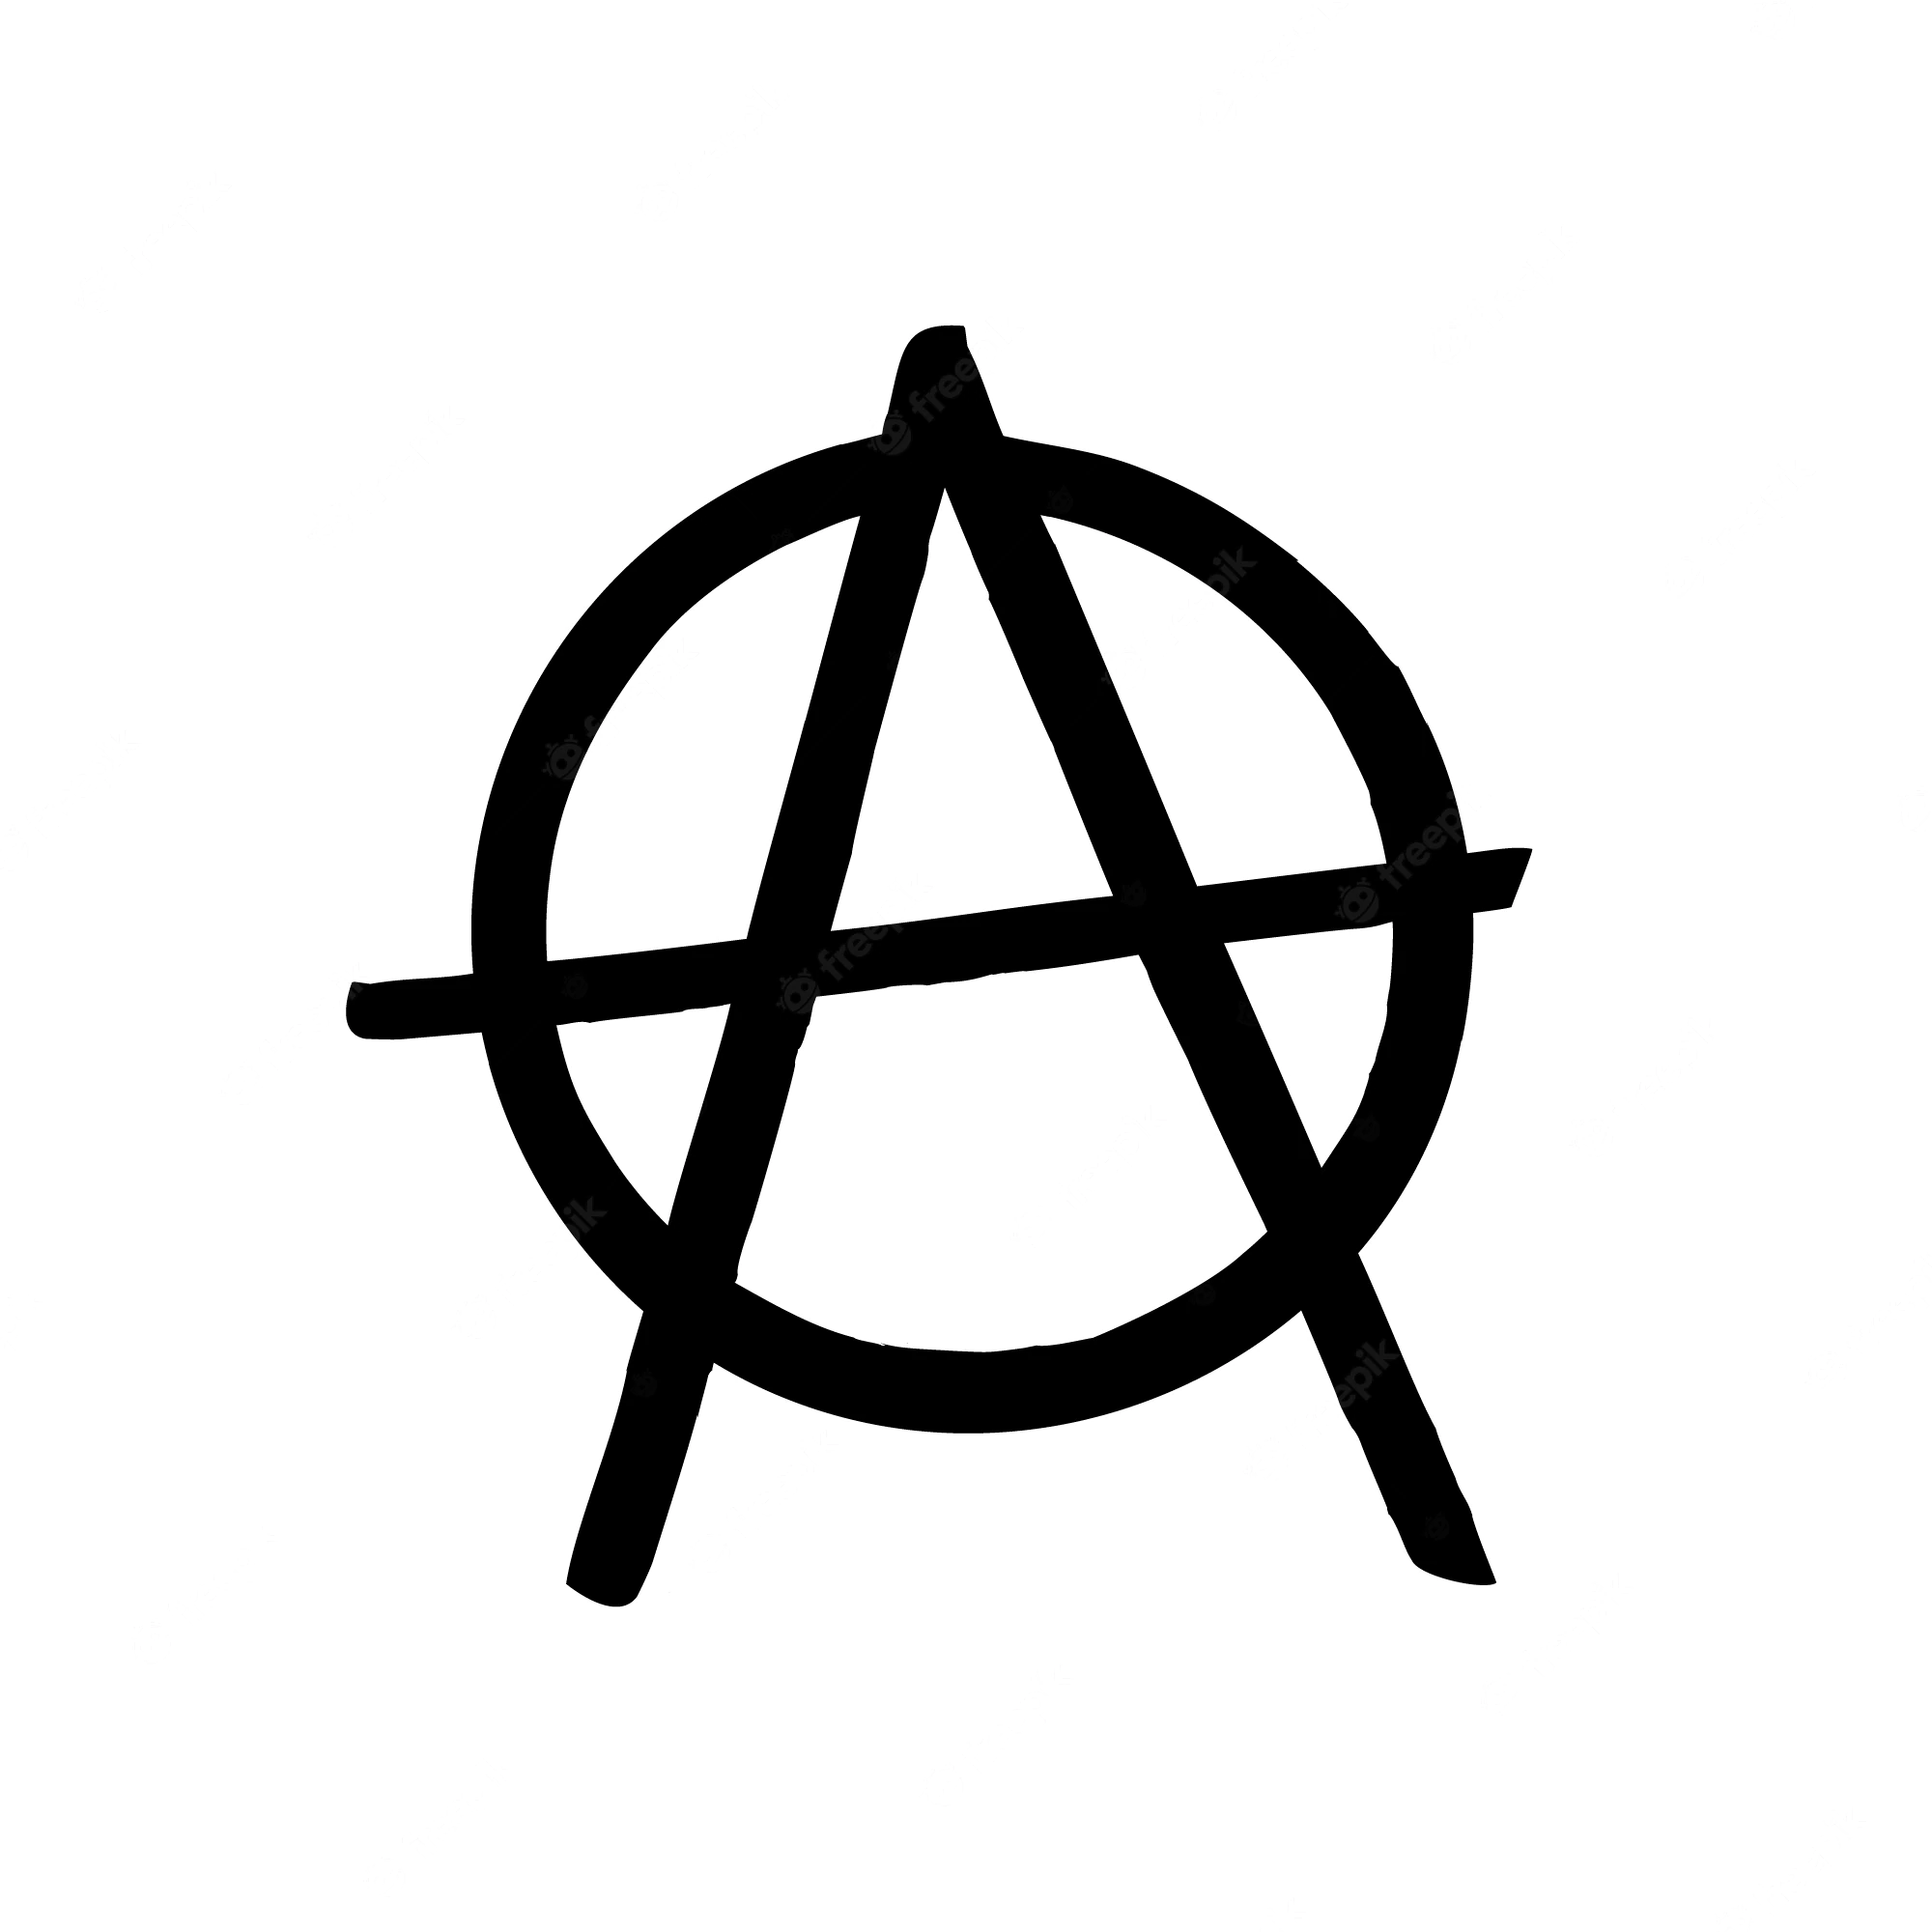


# Donate Anarchy.ai(site come soon) [here](https://link.trustwallet.com/send?coin=60&address=0x4DBd65ec0C0E91755e02170fC1C8f85FB4D6F4f9)


In [1]:
!git clone https://github.com/CompVis/stable-diffusion

fatal: destination path 'stable-diffusion' already exists and is not an empty directory.


In [2]:
cd stable-diffusion/

/home/kinakh/Development/Projects/Stable_Diffusion/stable-diffusion


In [ ]:
%%capture
!pip install albumentations==0.4.3
!pip install  opencv-python==4.1.2.30
!pip install pudb==2019.2
!pip install imageio==2.9.0
!pip install imageio-ffmpeg==0.4.2
#!pip install pytorch-lightning==1.4.2
!pip install  pytorch-lightning 
!pip install omegaconf==2.1.1
!pip install test-tube>=0.7.5
!pip install streamlit>=0.73.1
!pip install einops==0.3.0
!pip install torch-fidelity==0.3.0
!pip install transformers==4.19.2
!pip install -e git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
!pip install -e git+https://github.com/openai/CLIP.git@main#egg=clip
!pip install kornia

In [ ]:
mkdir  models/ldm/stable-diffusion-v1/

In [ ]:
# !wget https://drinkordiecdn.lol/sd-v1-3-full-ema.ckpt

In [ ]:
mv 'sd-v1-3-full-ema.ckpt' models/ldm/stable-diffusion-v1/model.ckpt

In [ ]:
import os
os.kill(os.getpid(), 9)

# Here runtime reloading, please press next to continue

In [ ]:
cd stable-diffusion/

In [ ]:
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

In [ ]:
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

In [ ]:
class config():
      def __init__(self):
        
        self.outdir = 'outputs/txt2img-samples'
        self.ddim_steps = 100
        self.plms = True
        
        self.laion400m = False
        self.seed = 42
        self.config = 'configs/stable-diffusion/v1-inference.yaml'
        self.ckpt = 'models/ldm/stable-diffusion-v1/model.ckpt'
        self.precision = 'autocast'
        self.n_rows = 0
        self.fixed_code = True
        self.from_file = False
        self.C = 4
        self.H = 128
        self.W = 128
        self.f = 4
        self.n_samples = 3
        self.n_iter = 1
        self.scale = 7.5
        self.ddim_eta = 0.0
        self.skip_save = False
        self.skip_grid = False

      
opt = config()

In [ ]:
if opt.laion400m:
        print("Falling back to LAION 400M model...")
        opt.config = "configs/latent-diffusion/txt2img-1p4B-eval.yaml"
        opt.ckpt = "models/ldm/text2img-large/model.ckpt"
        opt.outdir = "outputs/txt2img-samples-laion400m"

seed_everything(opt.seed)

config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")
model = model.half()



In [ ]:
def generate(opt,prompt):
    device = 'cuda'
    if opt.plms:
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)
    images = []
    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir

    batch_size = opt.n_samples
    n_rows = opt.n_rows if opt.n_rows > 0 else batch_size
    if not opt.from_file:

        assert prompt is not None
        data = [batch_size * [prompt]]

    else:
        print(f"reading prompts from {opt.from_file}")
        with open(opt.from_file, "r") as f:
            data = f.read().splitlines()
            data = list(chunk(data, batch_size))

    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))
    grid_count = len(os.listdir(outpath)) - 1

    start_code = None
    if opt.fixed_code:
        start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)

    precision_scope = autocast if opt.precision=="autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                #tic = time.time()
                all_samples = list()
                for n in trange(opt.n_iter, desc="Sampling"):
                    for prompts in tqdm(data, desc="data"):
                        uc = None
                        if opt.scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)
                        shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                        samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                         conditioning=c,
                                                         batch_size=opt.n_samples,
                                                         shape=shape,
                                                         verbose=False,
                                                         unconditional_guidance_scale=opt.scale,
                                                         unconditional_conditioning=uc,
                                                         eta=opt.ddim_eta,
                                                         x_T=start_code)

                        x_samples_ddim = model.decode_first_stage(samples_ddim)
                        x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)

                        if not opt.skip_save:
                            for x_sample in x_samples_ddim:
                                x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                                images +=[Image.fromarray(x_sample.astype(np.uint8))]
                                Image.fromarray(x_sample.astype(np.uint8)).save(
                                    os.path.join(sample_path, f"{base_count:05}.png"))
                                base_count += 1

                        if not opt.skip_grid:
                            all_samples.append(x_samples_ddim)

                if not opt.skip_grid:
                    # additionally, save as grid
                    grid = torch.stack(all_samples, 0)
                    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                    grid = make_grid(grid, nrow=n_rows)

                    # to image
                    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                    image = Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                    Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                    grid_count += 1
                print(f'Your images are here {outpath}')
                return images

In [ ]:
prompt = "minions with guns in chechen war hyper realism" #@param {type:"string"}
images = generate(opt, prompt=prompt)

In [ ]:
images[0]

In [ ]:
images[1]

In [ ]:
images[2]